## Linear and Logistic Regression 

This notebook will try to do 2 things 

* Explain the logic and maths behind linear and logistic regression 
* Show the implementation of the two methods upon real data 

### Linear Regression 

Simple linear regression is finding a straight line which minimizes the sum of squared errors between the predicted and actual values of the dependent variable. 

For a simple data set where we have one predictor(independent variable) and one prediction(dependent variable), we would get an equation like so:

$ y = mx + c  $

This can get more complicated with multiple predictors making equations that would look like this:

$ y = ax + bz + dv + c $

#### Performing Linear Regression on real data

We will look at this data set from kaggle: 

https://www.kaggle.com/datasets/girardi69/marathon-time-predictions?resource=download

This gives lots of data about marathon runners and we will use it to predict their time

##### Data Exploration and Cleaning 

In [2]:
import pandas as pd 
import numpy as np 

df_Marathons=pd.read_csv("MarathonData.csv")

df_Marathons.head()

,id,Marathon,Name,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime,CATEGORY
0,1,Prague17,Blair MORGAN,MAM,132.8,14.434783,NaN,1.16,2.37,A
1,2,Prague17,Robert Heczko,MAM,68.6,13.674419,NaN,1.23,2.59,A
2,3,Prague17,Michon Jerome,MAM,82.7,13.520436,NaN,1.30,2.66,A
3,4,Prague17,Daniel Or lek,M45,137.5,12.258544,NaN,1.32,2.68,A
4,5,Prague17,Luk ? Mr zek,MAM,84.6,13.945055,NaN,1.36,2.74,A


So we have these observations to help predict our MarathonTime

* Category:
    * the sex and age group of a runner
        * MAM Male Athletes under 40 years
        * WAM Women under 40 Years
        * M40 Male Athletes between 40 and 45 years

* km4week
    * This is the total number of kilometers run in the last 4 weeks before the marathon, marathon included. If, for example, the km4week is 100, the athlete has run 400 km in the four weeks before the marathon


* sp4week
    * This is the average speed of the athlete in the last 4 training weeks. The average counts all the kilometers done, included the slow kilometers done before and after the training. A typic running session can be of 2km of slow running, then 12-14km of fast running, and finally other 2km of slow running. The average of the speed is this number, and with time this is one of the numbers that has to be refined


* cross training:
    * If the runner is also a cyclist, or a triathlete, does it counts? Use this parameter to see if the athlete is also a cross trainer in other disciplines


* Wall21:
    * In decimal. The tricky field. To acknowledge a good performance, as a marathoner, I have to run the first half marathon with the same split of the second half. If, for example, I run the first half marathon in 1h30m, I must finish the marathon in 3h (for doing a good job). If I finish in 3h20m, I started too fast and I hit "the wall". My training history is, therefore, less valid, since I was not estimating my result


Lets get some descriptive metrics about the data


In [10]:
df_Marathons.info()
df_Marathons['Wall21']=pd.to_numeric(df_Marathons['Wall21'],errors='coerce')

df_Marathons.describe()

df_Marathons[['Category','CrossTraining']].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             87 non-null     int64  
 1   Marathon       87 non-null     object 
 2   Name           87 non-null     object 
 3   Category       81 non-null     object 
 4   km4week        87 non-null     float64
 5   sp4week        87 non-null     float64
 6   CrossTraining  13 non-null     object 
 7   Wall21         81 non-null     float64
 8   MarathonTime   87 non-null     float64
 9   CATEGORY       87 non-null     object 
dtypes: float64(4), int64(1), object(5)
memory usage: 6.9+ KB


,Category,CrossTraining
count,81,13
unique,6,5
top,MAM,ciclista 3h
freq,40,5


These descriptive states are very helpful but its nice to view paterns visualy so lets get a corr plot to check the correlations between these variables and marathon time 

Everything we put into the model must be numeric and also must be scaled as the model assumes that all variables are numeric and scaled so that it can accurately calculate the slope and intercept of the line. If variables are not numeric or scaled, then the model will not be able to accurately calculate these values

Lets do the scaling and numericising and then plot the correlation plot


In [45]:
df_dummies=pd.get_dummies(df_Marathons[['Category','CrossTraining']])

df_model=pd.concat([df_Marathons,df_dummies],axis = 1)

y=df_model['MarathonTime']

df_model=df_model.drop(columns=['Category','CrossTraining','Marathon','Name','CATEGORY','id','MarathonTime'])


from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

df_model=pd.DataFrame(scaler.fit_transform(df_model),index=df_model.index,columns=df_model.columns)

df_model= pd.concat([df_model,y],axis=1)

df_model.head()

,km4week,sp4week,Wall21,Category_M40,Category_M45,Category_M50,Category_M55,Category_MAM,Category_WAM,CrossTraining_ciclista 13h,CrossTraining_ciclista 1h,CrossTraining_ciclista 3h,CrossTraining_ciclista 4h,CrossTraining_ciclista 5h,MarathonTime
0,2.628775,-0.105867,-2.249753,-0.456435,-0.456435,-0.219529,-0.188982,1.083974,-0.219529,-0.107833,-0.107833,-0.246932,-0.153393,-0.219529,2.37
1,0.233311,-0.106509,-1.915123,-0.456435,-0.456435,-0.219529,-0.188982,1.083974,-0.219529,-0.107833,-0.107833,-0.246932,-0.153393,-0.219529,2.59
2,0.759417,-0.106639,-1.580493,-0.456435,-0.456435,-0.219529,-0.188982,1.083974,-0.219529,-0.107833,-0.107833,-0.246932,-0.153393,-0.219529,2.66
3,2.804144,-0.107704,-1.484884,-0.456435,2.190890,-0.219529,-0.188982,-0.922531,-0.219529,-0.107833,-0.107833,-0.246932,-0.153393,-0.219529,2.68
4,0.830311,-0.106280,-1.293667,-0.456435,-0.456435,-0.219529,-0.188982,1.083974,-0.219529,-0.107833,-0.107833,-0.246932,-0.153393,-0.219529,2.74


<AxesSubplot: >

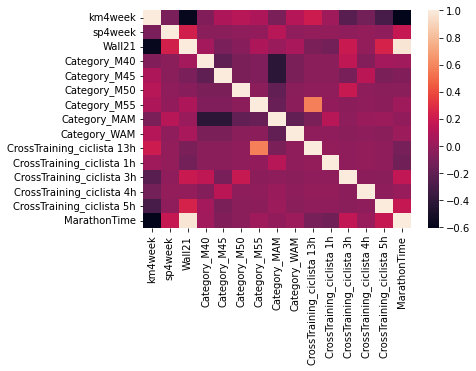

In [46]:
import seaborn as sns
corr = df_model.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

We have some intresting correlations

Wall21 is very highly correlated with Marathon Time as to be expected. It might be a little unfair to use this metric in the linear regression. If we got fresh data about marathon runners, we would have to wait till half way through the race to determine our prediction. 

Cross_Training ciclista 13_h is highly correlated with men over 55, likely due to people being only one a couple of people who are both 

We will discount Wall21 at this stage and keep the rest of the variables although they are liable to be removed so we can get a parsimonius model 

##### Modeling using ordinary least squares linear regression 

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = df_model.drop(columns=['MarathonTime','Wall21'])
y = df_model['MarathonTime']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

model = LinearRegression()

model.fit(X_train,y_train)

model.coef_


array([-0.2080052 ,  0.04335181, -0.05275253, -0.05837491, -0.0293284 ,
        0.01235615, -0.08531355, -0.02012259, -0.02618513, -0.04424652,
        0.00846228,  0.02655265, -0.03025547])

Unfortunately, sklearn doesn't have the best summary stats, so it might be best to use statsmodels for this kind of analysis

In [55]:
import statsmodels.api as sm

#add constant to predictor variables
X_train = sm.add_constant(X_train)

#fit linear regression model
model = sm.OLS(y_train, X_train).fit()

#view model summary
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:           MarathonTime   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     9.057
Date:                Sat, 21 Jan 2023   Prob (F-statistic):           5.36e-06
Time:                        20:37:36   Log-Likelihood:                -14.503
No. Observations:                  78   AIC:                             39.01
Df Residuals:                      73   BIC:                             50.79
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.3335      0.034     97.261   

From the output of statsmodels, we can see that the majority of these observations have a very limited impact on the overall prediction. The only statistically signficant observation is km4week which negatively correlates with marathon time 

We will also keep some predictors that have larger coefficients i.e > 0.05

* km4week
* Category_M40
* Category_M45
* Category_MAM

In [61]:
X = df_model[['km4week','Category_M40','Category_M45','Category_MAM']]
y = df_model['MarathonTime']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

model = LinearRegression()

model.fit(X_train,y_train)

model.score(X_test,y_test)

0.43377048945586105

43% accuracy, not great but thats sometimes how it goes with the data.

We could look to try find out the weather for the marathon/ do some feature egineering but lets leave this as is 

We can try some different types of linear model 

##### Ridge Regression 

